# Quantum Algorithms

In [2]:
import itertools
import warnings

warnings.filterwarnings("ignore")

import tensorcircuit as tc
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

tc.set_dtype("complex128")
K = tc.set_backend("jax")

In this chapter, we mainly focus on quantum algorithms of logical qubits, where quantum noise can be safely discarded due to fault tolerance architecture. The algorithms presented in this chapter have mathematically rigourous complexity scaling whose performance is guaranteed if we can build fault tolerant quantum computers in the future. However, the end-to-end performance advantage over classical algorithms can still be spurious especially for quadratic acceleration algorithms if we consider the error correction overhead and the actual running time [(ref)](https://dl.acm.org/doi/pdf/10.1145/3571725).

## Quantum algorithms with queries

The Deutsch-Jozsa problem showed an exponential quantum improvement over the best deterministic classical algorithms (but no acceleration over randomized classical algorithm); the Bernstein-Vazirani problem shows a polynomial improvement over the best randomized classical algorithms. We here focus on the more advantageous algorithm -- Simon's algorithm, where one can show exponential query complexity improvement in terms of randomized classical algorithms.

**Simon's algorithm:**
* $Z_2$ algebra: $\oplus$ or $+ (\mod 2)$. eg. $0+0=0, 0+1=1, 1+0=1, 1+1=0$. Generalize to bitwise adding: $01+10=11$, $110+100=010$. $i\cdot j=i_1j_1+\cdots i_nj_n$, eg. $3 \cdot 7 = 011\cdot 111 = 0+1+1=0$


* The problem: For $N = 2^n$, we are given function $f(x)$, with $x \in \{0,1\}^n$, with the property that there is some unknown non-zero $s \in \{0,1\}^n$ such that $f(i) = f(j)$ iff $(i = j$ or $i = j + s)$. The goal is to find $s$ (period of the function $f$, $f$ is a two-to-one function, $s=i+j$).

* The classical algorithm (upper bound): Birthday paradox. $T$ queries for one collison, probability roughly $T^2/2^n$. $T\sim 2^{n/2}$.

* The classical lower bound: match the upper bound (proof omitted here). $\Omega(2^{n/2})$

* The quantum algorithm: 

Simon's algorithm starts  in a state of 2n zero qubits $|0^n\rangle|0^n\rangle$ and apply Hadamard transforms to the first n qubits, giving

$$
\frac{1}{\sqrt{2^n}}\sum_{i\in\{0,1\}^n}|i\rangle|0^n\rangle
$$

At this point, the second n-qubit register still holds only zeroes. A query on $f$ ($U(f)\vert i\rangle \vert j\rangle = \vert i\rangle \vert j+f(i)\rangle$) turns this into

$$
\frac{1}{\sqrt{2^n}}\sum_{i\in\{0,1\}^n}|i\rangle|f(i)\rangle
$$

Now the algorithm measures the second n-bit register(this measurement is actually not necessary, but it facilitates analysis). The measurement outcome will be some value $x_i$ and the first register will collapse to the superposition of the two indices having that $f$-value:

$$
\frac{1}{\sqrt{2}}(|i\rangle+|i\oplus s\rangle)|f(i)\rangle.
$$

We will now ignore the second register and apply Hadamard transforms to the first n qubits. Using the fact that $(i\oplus s)\cdot j=(i\cdot j)\oplus(s\cdot j)$, we can write the resulting state as

$$
\frac{1}{\sqrt{2^{n+1}}}\left(\sum_{j\in\{0,1\}^n}(-1)^{i\cdot j}|j\rangle+\sum_{j\in\{0,1\}^n}(-1)^{(i\oplus s)\cdot j}|j\rangle\right)=
\frac{1}{\sqrt{2^{n+1}}}\left(\sum_{j\in\{0,1\}^n}(-1)^{i\cdot j}(1+(-1)^{s\cdot j})|j\rangle\right).
$$

Note that $|j\rangle$ has non-zero amplitude iff $s\cdot j=0 \mod 2$. Measuring the state gives a uniformly random element from the set $\{j\mid s\cdot j=0\mod 2\}$. Accordingly, we get a linear equation that gives information about s. We repeat this algorithm until we have obtained $n-1$ independent linear equations involving s. The solutions to these equations will be $0^n$ and the correct s, which we can compute efficiently by a classical algorithm (Gaussian elimination).

Expected quantum queries $O(n)$.

The circuit schematic is shown as:

<img src="../static/simon.png">

*Excercise:* Implementation of Simon's algorithm.

input:  (0, 0, 0)
output:  (0, 0, 0)
input:  (0, 0, 1)
output:  (0, 0, 1)
input:  (0, 1, 0)
output:  (0, 1, 0)
input:  (0, 1, 1)
output:  (0, 1, 1)
input:  (1, 0, 0)
output:  (0, 1, 1)
input:  (1, 0, 1)
output:  (0, 1, 0)
input:  (1, 1, 0)
output:  (0, 0, 1)
input:  (1, 1, 1)
output:  (0, 0, 0)
bitstrings orthogonal with s in Z2 algebra:
00110 * 01110 = 0
01011 * 01110 = 0
01100 * 01110 = 0
01100 * 01110 = 0
10001 * 01110 = 0


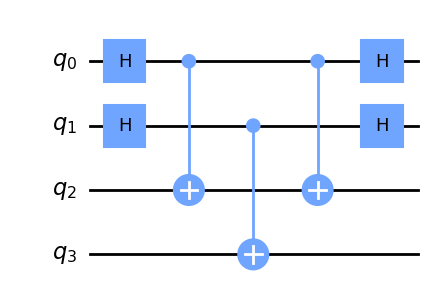

In [27]:
def oracle(c, s: str):
    n = c._nqubits // 2
    for i in range(n):
        c.cnot(i, i + n)
    for i, j in enumerate(s):
        if j == "1":
            for k, l in enumerate(s):
                if l == "1":
                    c.cnot(i, k + n)
            break
    return c


# check the oracle satisy simon algorithm promise

for init in itertools.product(*[[0, 1] for _ in range(3)]):
    c = tc.Circuit(6)
    for i, j in enumerate(init):
        if j == 1:
            c.x(i)
    print("input: ", init)
    out = oracle(c, "111").sample()[0]
    print("output: ", tuple([int(o) for o in out[3:]]))


def simon_circuit(n, s: str):
    c = tc.Circuit(2 * n)
    for i in range(n):
        c.H(i)
    c = oracle(c, s)
    for i in range(n):
        c.H(i)
    return c


def simon_alg(n, s: str, trials: int):
    c = simon_circuit(n, s)
    return c.sample(batch=trials, format="count_dict_bin")


r = simon_alg(5, "01110", 5)

print("bitstrings orthogonal with s in Z2 algebra:")
for s in r.keys():
    print(f"{s[:5]} * 01110 = {(int(s[:5], 2)&int('01110', 2))%2}")

simon_circuit(2, "10").draw(output="mpl")

**Grover's algorithm:**

* The problem: for $N=2^n$ all bitstring inputs $i\in \{0, 1\}^n$, identify the input $i$ where $f(i)=1$, otherwise $f(j)=0$.

* Classical lower bound: $2^n$ queries to find the possible only solution.

* The quantum algorithm: consecutive application of two unitaries (one involving the query $U_f$) $O(\sqrt{N})$ times from an initially even superposition of all computational states.


* Quantum lower bound: quadratic speed up $2^{n/2}$ queries matches the lower bound (Grover's algorithm is quantum optimal for unstructured search).

Comment: in query models, $f$ is assumed to be a black box, i.e. no prior structure of $f$ can be utilized. For specific search problem with explicit structure of $f$, better algorithm than the lower bound could be possible.

**Amplitude amplification:**

The analysis for Grover's algorithm is actually much more generally applicable. Let $\chi: Z\rightarrow\{0,1\}$ be any Boolean function; inputs $z\in Z$ satisfying $\chi(z)=1$ are called solutions. Suppose we have an algorithm to check whether $z$ is a solution. This can be written as a unitary $O_{\chi}$ that maps $|z\rangle\mapsto(-1)^{\chi(z)}|z\rangle$. Suppose also we have some (quantum or classical) algorithm $\mathcal{A}$ that uses no intermediate measurements and has probability $p$ of finding a solution when applied to starting state $|0\rangle$. Classically, we would have to repeat $\mathcal{A}$ roughly $1/p$ times before we successfully find a solution. The amplitude amplification algorithm below only needs to run $\mathcal{A}$ $O(1/\sqrt{p})$ times:

1. Setup the starting state $|U\rangle=\mathcal{A}|0\rangle$

2. Repeat the following two unitaries $O(1/\sqrt{p})$ times:

   (a) Grover's oracle (i.e., apply $O_{\chi}$)

   (b) Grover's reflection (i.e., apply $\mathcal{A }(2\vert 0^n\rangle \langle 0^n\vert-1)\mathcal{A}^{-1}$)

3. Measure the first register and check that the resulting element $x$ is the solution.

Henceforce, amplitude amplification provides a very general way of quadratic acceleration compared to classical method. When the algorithm $\mathcal{A}$ is $H^n$, the algorithm is reduced back to Grover's search.

*Excercise:* Implementation of Grover's algorithm.

In [37]:
def grover_oracle(c, n, solution):
    c.multicontrol(*range(n + 1), unitary=tc.gates.x(), ctrl=[i for i in solution])
    return c
    # answer bitstring is solution
    # the function is a simplified oracle


def grover_reflection(c, n):
    for i in range(n):
        c.H(i)
        c.X(i)
    c.multicontrol(*range(n), unitary=tc.gates.z(), ctrl=[1 for _ in range(n - 1)])
    for i in range(n):
        c.X(i)
        c.H(i)
    return c


def grover_algorithm(n, r, solution):
    # note solution is hidden in real application
    c = tc.Circuit(n + 1)
    c.X(n)
    for i in range(n + 1):
        c.H(i)
    for _ in range(r):
        c = grover_oracle(c, n, solution)
        c = grover_reflection(c, n)
    return c


n = 6
r = int(np.pi / 4 * np.sqrt(2**n))
print("The optimal number of queries: ", r)

c = grover_algorithm(n, r, [1, 0, 0, 0, 1, 1])
r = c.sample(allow_state=True, batch=8, format="count_dict_bin")
print(r)

The optimal number of queries:  6
{'1000110': 6, '1000111': 2}


## Dynamics simulation via Trotterization

Quantum computer can efficiently simulate the dynamics digitally with controllable error. Indeed, dynamics simulation is BQP-complete, or easy on quantum computers. The most straightforward way to simulate $\vert \psi_t\rangle = e^{-i H t}\vert \psi_0\rangle$ is by trotterization, where we have 

$$
e^{-i (H_1+H_2)\Delta t} \approx  e^{-i H_1 \Delta t} e^{-i H_2\Delta t}+O(\Delta t^2).
$$

Therefore, by decomposing the Hamiltonian into commutable terms and choose appropriate time slice $\Delta t$, we can realize dynamics simulation with $O(poly(n)*t)$ quantum resources. 

On classical computers, storing the wavefunction $\vert \psi_t\rangle$ already requires exponential space.

*Excercise:* Implementation of dynamics simulation for the Heisenberg model using Trotterization. (Recalling Rzz gate as $\text{Rzz}(\theta)_{ij}=e^{-i\theta/2 Z_i Z_j}$)

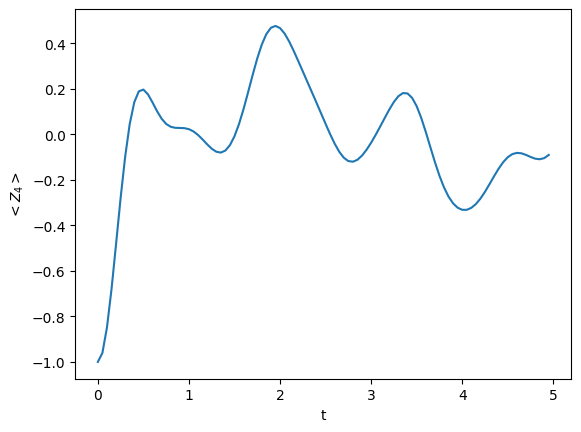

In [92]:
# baseline

L = 8
g = tc.templates.graphs.Line1D(L, pbc=False)
h = tc.quantum.heisenberg_hamiltonian(g, sparse=False)


@K.jit
def time_evolution_baseline(t):
    # Z4
    c = tc.Circuit(L)
    c.X(range(0, L - 1, 2))
    s0 = c.state()
    s = K.expm(-1.0j * h * t) @ K.reshape(s0, [-1, 1])
    c = tc.Circuit(L, inputs=s)
    return K.real(c.expectation_ps(z=[L // 2]))


history = []
for t in np.arange(0, 5, 0.05):
    history.append(time_evolution_baseline(t))

plt.plot(np.arange(0, 5, 0.05), history)
plt.xlabel("t")
plt.ylabel(r"$<Z_4>$")
plt.show()

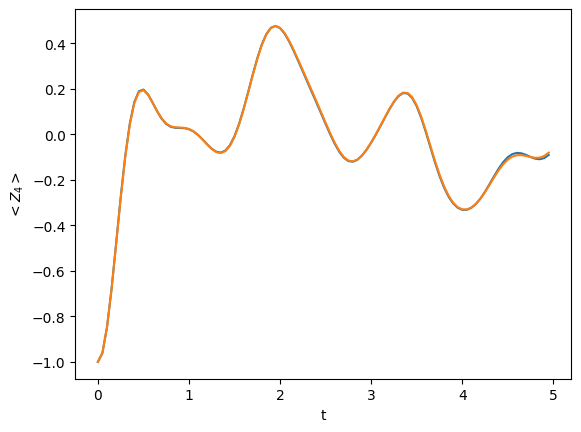

In [94]:
@K.jit
def time_evolve_step(inputs, dt):
    c = tc.Circuit(L, inputs=inputs)
    for i in range(0, L - 1):
        c.ryy(i, i + 1, theta=2 * dt)
    for i in range(0, L - 1):
        c.rzz(i, i + 1, theta=2 * dt)
    for i in range(0, L - 1):
        c.rxx(i, i + 1, theta=2 * dt)
    inputs = c.state()
    return inputs


def time_evolution(steps, dt):
    rs = []
    c = tc.Circuit(L)
    c.X(range(0, L - 1, 2))
    rs.append(K.real(c.expectation_ps(z=[L // 2])))
    for _ in range(steps - 1):
        s = c.state()
        s = time_evolve_step(s, dt)
        c = tc.Circuit(L, inputs=s)
        rs.append(K.real(c.expectation_ps(z=[L // 2])))
    return rs


history_trotter = time_evolution(100, 0.05)

plt.plot(np.arange(0, 5, 0.05), history)
plt.plot(np.arange(0, 5, 0.05), history_trotter)
plt.xlabel("t")
plt.ylabel(r"$<Z_4>$")
plt.show()

## Ground state simulation via phase estimation

**Quantum phase estimation (QPE):** 

* The problem: given a unitary operator $U$ ($n$-qubit, $2^n\times 2^n$ matrix) and the related eigenstate $\vert \psi\rangle$ such that $U \vert \psi\rangle = e^{i\theta}\vert \psi\rangle$, phase estimation is a quantum algorithm that can output the eigenvalue $\theta$ upto any precision $\varepsilon$ using $n+O(\log 1/\varepsilon)$ qubits and $O(1/\varepsilon)$ control-U operations.

* The more amazing part of the algorithm is by linearity, if the input state is an abitrary state $\sum_ic_i\vert \psi_i\rangle$, the output readout is still the eigenvalue for $\theta_i$ related to $\vert \psi_i\rangle$ with probability $|c_i|^2$. In other words, we diagonalize the exponential size unitary matrix (know at least one eigenvalue) for $poly(n)$ resources!

* If $U=e^{-iHt}$ is a Hamiltonian simulation primitive as shown in the last section, the readout eigenvalue phase $\theta$ is related with one of the eigen-energy of the system $H$. If the input state has $poly(1/n)$ overlap with the ground state of $H$, we can read the exact ground state eigen-energy using QPE in $poly(n)$ trials. This is a very promising way to evaluate ground state energy of $H$.

* Complexity considerations: unlike dynamical problem, the ground state problem for a quantum Hamiltonian is in general QMA-complete, namely, ground state problem is still hard on quantum computers. The reason is that, although we can apply QPE algorithms, to ensure we can obtain the lowest eigenvalue with $poly(n)$ trials, the inputs state must admit a $poly(1/n)$ overlap with the ground state, which is already hard to realize in general on quantum computers.

The schematic circuit for phase estimation is shown as:

<img src="../static/qpe.png">

See the details of the algorithm in [ref](https://pennylane.ai/qml/demos/tutorial_qpe).

**Period finding and Shor's algorithm:**

The factoring problem can be classically reduced to a period finding problem on a classical function $f$, similar to Simon's algorithm case. For the quantum oracle of function $U_f$, the period information is hidden in the eigenvalues of $U_f$ (the denominator). Therefore, by applying QPE, we can find the function period efficiently which turns out to be classically related with factoring results.